## Import

In [1]:
# this is for google colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os 

# tool_path = "/content/drive/Shared drives/Shared Task SentiMix/tools"

# import tools

# import tools.baseline as bt
# import tools.data as data_tools
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, Dropout, Conv1D, GlobalMaxPool1D
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.optimizers import Adam
from collections import defaultdict
import json

from keras.layers import *


Using TensorFlow backend.


In [3]:
def read_corpus(corpus_file):
    """read input document and return the textual articles
    and either the bias or hyperpartisan label"""

    with open(corpus_file) as json_file:
        data = json.load(json_file)

    data = pd.DataFrame(data)
    documents = data.text
    labels_bin = data.hyperp
    labels_mult = data.bias
    titles = data.title


    return documents, labels_bin, labels_mult, titles

## Import Data

In [4]:
X, Y_bin, Y_mult, titles = read_corpus('tokenized_with_NUM.json')

In [5]:
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size = 0.2)

Xtrain = X[train_idx]
Xtest = X[test_idx]

Ytrain_bin = Y_bin[train_idx]
Ytest_bin = Y_bin[test_idx]

Ytrain_mult = Y_mult[train_idx]
Ytest_mult = Y_mult[test_idx]

titles_train = titles[train_idx]
titles_test = titles[test_idx]

In [6]:
toki = Tokenizer()
toki.fit_on_texts(Xtrain)

title_tok = Tokenizer()
title_tok.fit_on_texts(titles_train)

In [7]:
Xtrain_seq = toki.texts_to_sequences(Xtrain)
Xtest_seq = toki.texts_to_sequences(Xtest)

titles_train = title_tok.texts_to_sequences(titles_train)
titles_test = title_tok.texts_to_sequences(titles_test)

In [8]:
t_vocab = len(title_tok.word_index)

In [9]:
word2index = toki.word_index
word2index['PAD'] = 0

In [10]:
index2word = toki.index_word
index2word[0] = 'PAD'
print(index2word[0])

PAD


In [11]:
#get max length of words

lens = [len(text) for text in Xtrain]

max_article_len = max(lens)
mean_article_len = np.mean(lens)
print(max_article_len, mean_article_len)

max_len = 1000

3103 592.4747231584015


In [12]:
t_lens = [len(t) for t in titles_train]
t_max = max(t_lens)
print(t_max)

86


In [13]:
#pre-pad the tweets with value 0
# that is prepadding (Louis so you understand as well)
Xtrain_pad = pad_sequences(Xtrain_seq, maxlen = max_len)
Xtest_pad = pad_sequences(Xtest_seq, maxlen = max_len)

t_train_pad = pad_sequences(titles_train, maxlen = t_max)
t_test_pad = pad_sequences(titles_test, maxlen = t_max)

### Labels

In [14]:
Ytrain_bin[:3]

2463     True
1273    False
2468     True
Name: hyperp, dtype: bool

In [15]:
Ytrain_bin = np.asarray([0. if l == False else 1. for l in Ytrain_bin])
Ytest_bin = np.asarray([0. if l == False else 1. for l in Ytest_bin])

In [16]:
# Ytrain_bin = to_categorical(Ytrain_bin)
# Ytest_bin = to_categorical(Ytest_bin)

In [17]:
Ytest_bin[:3]

array([1., 1., 0.])

In [18]:
mult_labels = set(Ytrain_mult)

In [19]:
label_dict = defaultdict()
for i, l in enumerate(mult_labels):
    label_dict[l] = i
    
print(label_dict)

defaultdict(None, {'left': 0, 'least': 1, 'left-center': 2, 'right': 3, 'right-center': 4})


In [20]:
Ytrain_mult = [label_dict[label] for label in Ytrain_mult]
Ytest_mult = [label_dict[label] for label in Ytest_mult] 

# this is now a list of numbers

In [21]:
no_cls = len(label_dict)

Ytrain_mult_cat = np.asarray([to_categorical(label, num_classes = no_cls) for label in Ytrain_mult])
Ytest_mult_cat = np.asarray([to_categorical(label, num_classes = no_cls) for label in Ytest_mult])

In [22]:
print('Shape of data tensor:', Xtrain_pad.shape)
print('Shape of title tensor:', t_train_pad.shape)
print('Shape of binary label tensor:', Ytrain_bin.shape)
print('Shape of multilabel tensor:', Ytrain_mult_cat.shape)

Shape of data tensor: (2077, 1000)
Shape of title tensor: (2077, 86)
Shape of binary label tensor: (2077,)
Shape of multilabel tensor: (2077, 5)


### Prepare the Embedding Layer

In [23]:
w2v_path = 'data/GoogleNews-vectors-negative300.bin'
embeddings = Word2Vec.load('model_all.bin')
embed_len = 100


#embed_w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [24]:
#w = filter(lambda x: x in model.vocab, list(model.wv.vocab))
#print model.most_similar(positive=w)

def load_embeddings(model, i2w, embed_len):
    
    index2embed = dict()
    w = filter(lambda x: x in word2index.keys(), list(embeddings.wv.vocab))

    for i, w in i2w.items():
        try:
            embed = model[w]
        except KeyError:
            embed = np.zeros(embed_len)
            #embed = embeddings.most_similar(positive=w)
        index2embed[i] = embed
    
    return index2embed

def load_w2v(model,i2w):
    index2emb = dict()
    
    for i, w in i2w.items():
        try:
            embed = model[w]
        except KeyError:
            embed = model['UNK']
            #embed = embeddings.most_similar(positive=w)
        index2embed[i] = embed
    
    return index2embed


In [25]:
#index2embed = loadw2v(embed_w2v, index2word)
index2embed = load_embeddings(embeddings, index2word, embed_len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [26]:
#compute embedding matrix

embedding_matrix = np.zeros((len(word2index) + 1, embed_len))
for word, i in word2index.items():
    embedding_vector = index2embed[i]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [27]:
#load embedding matrix into embedding layer


embedding_layer = Embedding(len(word2index) + 1,
                            embed_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### Build title embeddings

In [28]:
import gensim


with open('tokenized_with_NUM.json') as json_file:
    data = json.load(json_file)

data = pd.DataFrame(data)
#print(data.columns.values)

X = data['title'].tolist()

t_model = gensim.models.Word2Vec(X, size=100)
#w2v = dict(zip(model.wv.index2word, model.wv.syn0))
words = list(t_model.wv.vocab)
vocab_length = len(words)
t_model.save('model_titles.bin')

In [29]:
title_i2e = load_embeddings(t_model, title_tok.index_word, embed_len = 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [30]:
# build title embedding matrix
title_em = np.zeros((len(title_tok.index_word) + 1, embed_len))
for word, i in title_tok.word_index.items():
    embedding_vector = title_i2e[i]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        title_em[i] = embedding_vector

In [31]:
#load embedding matrix into embedding layer

title_el = Embedding(len(title_tok.word_index) + 1,
                     embed_len,
                     weights=[title_em],
                     input_length=t_max,
                     trainable=False)

### Building the classifier - CNN

In [32]:
def cnn(binary, embedding = embedding_layer, lr = 0.001, hidden = 250):
    
    if binary:
        loss = 'binary_crossentropy'
        out = 1
        act_out = 'sigmoid'
    else:
        loss = 'categorical_crossentropy'
        out = 5
        act_out = 'softmax'
    
    
    filters = 250
    kernel_size = 3
    optim = Adam(lr=lr)
    
    
    input_titles = Input(shape=(t_max,))
    t_embed = title_el(input_titles)
    
    sequence_input = Input(shape=(max_len,), dtype='int32')
    
    embedded_sequences = embedding_layer(sequence_input)
    
    conc = Concatenate(axis=1)([t_embed, embedded_sequences])

    drop1 = Dropout(0.2)(conc)

    conv1 = Conv1D(filters,
                  kernel_size,
                  padding = 'valid',
                  activation = 'relu',
                  strides = 1)(drop1)

    pool = GlobalMaxPool1D()(conv1)

    dense1 = Dense(hidden, activation='relu')(pool)
    drop2 = Dropout(0.2)(dense1)
    output = Dense(out, activation = act_out)(drop2)
    model = Model(inputs=[input_titles, sequence_input], outputs=output)
    model.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

    model.summary()
    
    return model

In [33]:
model_bin = cnn(binary = True)
model_mult = cnn(binary = False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 86)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 86, 100)      641900      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    4316500     input_2[0][0]                   

In [34]:
epochs = 30
batch = 1024
history_bin = model_bin.fit([t_train_pad,Xtrain_pad],
                            Ytrain_bin, 
                            batch_size=batch,
                            epochs=epochs,
                            validation_split=0.1,
                            verbose=1)


Epoch 1/30
2077/2077 [==============================] - 7s 4ms/step - loss: 3.6695 - accuracy: 0.4858
Epoch 2/30
2077/2077 [==============================] - 7s 4ms/step - loss: 2.1734 - accuracy: 0.5055
Epoch 3/30
2077/2077 [==============================] - 7s 4ms/step - loss: 1.3566 - accuracy: 0.5296
Epoch 4/30
2077/2077 [==============================] - 8s 4ms/step - loss: 1.8411 - accuracy: 0.5267
Epoch 5/30
2077/2077 [==============================] - 8s 4ms/step - loss: 1.2466 - accuracy: 0.5392
Epoch 6/30
2077/2077 [==============================] - 8s 4ms/step - loss: 1.0331 - accuracy: 0.5850
Epoch 7/30
2077/2077 [==============================] - 8s 4ms/step - loss: 1.1321 - accuracy: 0.5725
Epoch 8/30
2077/2077 [==============================] - 8s 4ms/step - loss: 0.8556 - accuracy: 0.6302
Epoch 9/30
2077/2077 [==============================] - 8s 4ms/step - loss: 0.9303 - accuracy: 0.6143
Epoch 10/30
2077/2077 [==============================] - 8s 4ms/step - loss: 0.80

In [35]:
epochs = 20
batch = 256
history_mult = model_mult.fit([t_train_pad,Xtrain_pad], 
                              Ytrain_mult_cat, 
                              batch_size=batch, 
                              epochs=epochs, 
                              validation_split = 0.01,
                              verbose=1)

Epoch 1/20
2077/2077 [==============================] - 8s 4ms/step - loss: 3.7761 - accuracy: 0.2436
Epoch 2/20
2077/2077 [==============================] - 8s 4ms/step - loss: 2.2792 - accuracy: 0.2807
Epoch 3/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.6743 - accuracy: 0.3361
Epoch 4/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.3987 - accuracy: 0.4218
Epoch 5/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.2766 - accuracy: 0.4646
Epoch 6/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.2221 - accuracy: 0.4738
Epoch 7/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.1717 - accuracy: 0.5123
Epoch 8/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.1362 - accuracy: 0.5373
Epoch 9/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.0830 - accuracy: 0.5489
Epoch 10/20
2077/2077 [==============================] - 8s 4ms/step - loss: 1.046

In [36]:
import matplotlib.pyplot as plt

def plot_history(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['loss'])
    #plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    #plt.legend(['Acc', 'Loss'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

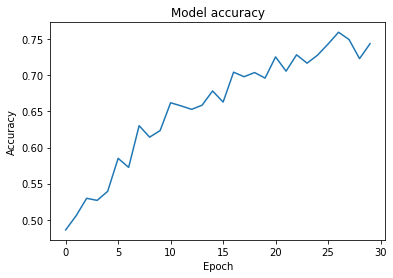

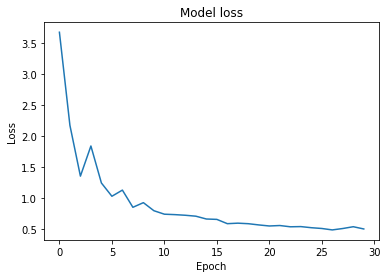

In [37]:
plot_history(history_bin)

In [38]:
predictions_bin = model_bin.predict([t_test_pad, Xtest_pad])

In [39]:
def report(true, pred):
    # binary classification returns a matrix with shape (X,1),
    # multiclass returns shape (X,5)
    if pred.shape[1] == 1:
        pred_converted = [0 if p < 0.5 else 1 for p in pred]
    else:
        pred_converted = np.argmax(pred, axis=1)
        
    print(classification_report(true, pred_converted))
    
    return 
        

In [40]:
report(Ytest_bin, predictions_bin)

              precision    recall  f1-score   support

         0.0       0.89      0.57      0.70       271
         1.0       0.66      0.92      0.77       249

    accuracy                           0.74       520
   macro avg       0.77      0.75      0.73       520
weighted avg       0.78      0.74      0.73       520



In [41]:
pred_mult = model_mult.predict([t_test_pad, Xtest_pad])
report(Ytest_mult, pred_mult)

              precision    recall  f1-score   support

           0       0.48      0.75      0.58       122
           1       0.72      0.52      0.60        92
           2       0.49      0.36      0.41        90
           3       0.71      0.57      0.63       127
           4       0.69      0.74      0.72        89

    accuracy                           0.59       520
   macro avg       0.62      0.59      0.59       520
weighted avg       0.62      0.59      0.59       520

